In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import loadGeographicData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
CYCLE = 10020
DOWNSAMPLING = 1

In [4]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [5]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [6]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

In [7]:
df = pd.read_csv(f"data/processed/snapshots/{CYCLE}.csv.gz", compression="gzip")

In [8]:
cepii = loadGeographicData.load_inter_country_distances("data/external/cepii/dist_cepii.csv", 
                                                        "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


In [9]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)

In [10]:
all_vals = []
cc_list = []
rtt_vals = []
for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]
    cc_str_1 = f"{cc1}-{cc2}"
    cc_str_2 = f"{cc2}-{cc1}"
    if (cc_str_1 not in cc_list) and (cc_str_2 not in cc_list):
        cc_list.append(cc_str_1)
    rtt_vals.append(weight["diff_rtt"])
    all_vals.append((cc1, cc2, weight["diff_rtt"]))

In [11]:
l = []

for str_cc in cc_list:
    cc1, cc2 = str_cc.split("-")
    l.append((cc1, cc2))

cc_graph = pd.DataFrame(l, columns=["cc1", "cc2"])
cc_graph = cc_graph.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
cc_graph.head()


,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219


In [12]:
all_vals = pd.DataFrame(all_vals, columns=["cc1", "cc2", "diff_rtt"])
all_vals = all_vals.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
all_vals.head()

,cc1,cc2,diff_rtt,dist
0,AE,CH,114.876,4407.826551
1,CH,JP,209.294,9214.366906
2,CH,JP,211.329,9214.366906
3,AE,DE,67.622,4266.720006
4,DE,US,80.180,5297.217204


In [13]:
H = nx.from_pandas_edgelist(
   cc_graph,
    "cc1",
    "cc2",
)

print(f"nodes: {len(G.nodes())}")
print(f"edges: {len(G.edges())}")
print(f"countries: {len(H.nodes())}")



nodes: 31773
edges: 85620
countries: 170


In [14]:
d = pd.DataFrame([(node, val) for (node, val) in G.degree()], columns=["node", "degree"])

In [15]:
ds = d.groupby("degree")["node"].count().reset_index()
ds = ds.sort_values("degree")

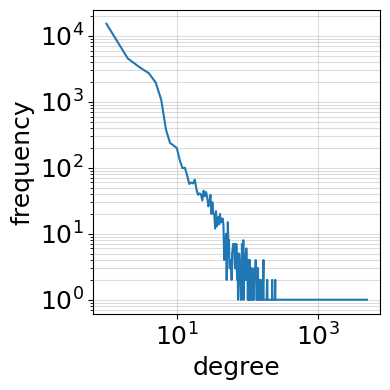

In [16]:
fig, ax = plt.subplots(1, figsize=(4, 4))

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')

ax.plot(
    ds["degree"].values,
    ds["node"].values,
)

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(labelsize=18)
ax.set_xlabel("degree", fontsize=18)
ax.set_ylabel("frequency", fontsize=18)


fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/lhls/node_degree.pdf")